In [ ]:
import keras
print(keras.__version__) # 2.11.0


2.11.0


In [31]:
#!pip install --upgrade tensorflow
#!pip install --upgrade scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
#install necessary libraries

import numpy as np
import matplotlib
import tensorflow as tf  
from sklearn import metrics
import random
from random import randint
import time
import os
import yaml
import time
import pickle
import logging
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from yaml.loader import SafeLoader
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import LSTM, Dense,Dropout
from tensorflow.python.keras.metrics import Precision
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping



## Read JSON Files & Create a single Numpy array

In [40]:
import os
import json
import numpy as np

def load_data(directories):
    X = []
    Y = []
    
    for dir in directories:
        for file in os.listdir(dir):
            with open(os.path.join(dir, file)) as f:
                data = json.load(f)
                X.append(data)
                if "Agressive" in dir:
                    Y.append(1)
                else:
                    Y.append(0)

    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

# Train data
directories = ["/content/drive/MyDrive/GDP/train/Agressive", "/content/drive/MyDrive/GDP/train/Peaceful"] # provide the directory paths to read the train data from 
X, Y = load_data(directories)

num_json,num_frame,num_people,total_num_keypoints = X.shape 

# Test data
directories_test = ["/content/drive/MyDrive/GDP/test/Agressive","/content/drive/MyDrive/GDP/train/Peaceful"] # provide the directory paths to read the test data from 
X_test, Y_test = load_data(directories_test)
num_json_test = X_test.shape[0]



In [46]:
num_json,num_frame,num_people,total_num_keypoints 

(71, 30, 6, 42)

In [19]:
X,Y
# X_test, Y_test

In [47]:
"""
X.shape and X_test.shape should be (num_json, 30, num_people, 14*3)

while Y.shape and Y_test.shape should be (num_json,)

"""
X.shape, Y.shape 
# X_test.shape, Y_test.shape

((71, 30, 6, 42), (71,))

## 1. Data Preprocessing

In [48]:
"""
Reshape X and X_test np arrays so that the dimension is converted into 3 dimensions array to be used in LSTM

"""

def reshape_x(X):
  num_json = X.shape[0] 
  X_reshaped = X.reshape(num_json,num_frame,-1) 
  return X_reshaped

X_reshaped = reshape_x(X)
X_test_reshaped = reshape_x(X_test)



In [50]:
X_reshaped.shape # (num_json, num_frame=30, num_keypoints*num_people)
X_test_reshaped.shape # (num_json, num_frame=30, num_keypoints*num_people)

(47, 30, 252)

## 2. Modeling 

In [28]:
# Initial Model 

model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(num_frame, num_people*total_num_keypoints)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:

model.fit(X_reshaped,
          Y, epochs=5)


Epoch 1/5
1/1 [==============================] - 10s 10s/step - loss: 0.7194 - accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 161ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 169ms/step - loss: 0.7337 - accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 163ms/step - loss: 0.7046 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 151ms/step - loss: 0.6916 - accuracy: 0.5000


### Hyperparameter Tuning

In [ ]:
tf.autograph.set_verbosity(0)

from tensorflow.keras.layers import LSTM # critical because you may get some error if you import LSTM from another library
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.regularizers import l1_l2

# Define a function that creates LSTM model

def create_model(dropout_rate=0.2, epochs=5, batch_size=32):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(num_frame, num_people*total_num_keypoints)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(256, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, return_sequences=False, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create a KerasClassifier from your function

kc_model = KerasClassifier(model=create_model, verbose=0,dropout_rate=0.2)



# Define the hyperparameters that will be tuned
params = {
    'dropout_rate': np.arange(0.1,0.5,0.01), 
    'epochs': np.arange(50,200,50) , 
    'batch_size': [32, 64,128], 
    'optimizer' : ['sgd','Adam']
}




# Create a GridSearchCV object with the model and hyperparameters, using the StratifiedKFold object for cross-validation
grid_search = GridSearchCV(kc_model, params, scoring='accuracy')

# Fit the GridSearchCV object to your data
grid_search.fit(X_reshaped, Y)


# Print the best hyperparameters and their corresponding Accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_batch_size = grid_search.best_params_['batch_size']
best_dropout_rate = grid_search.best_params_['dropout_rate']
best_epochs= grid_search.best_params_['epochs']
best_optimizer = grid_search.best_params_['optimizer']

### Final Model with Tuned Hyperparameters

Epoch 1/10
2/2 [==============================] - 10s 395ms/step - loss: 30.7886 - accuracy: 0.4930
Epoch 2/10
2/2 [==============================] - 1s 369ms/step - loss: 30.6903 - accuracy: 0.4930
Epoch 3/10
2/2 [==============================] - 1s 375ms/step - loss: 30.5774 - accuracy: 0.5915
Epoch 4/10
2/2 [==============================] - 1s 389ms/step - loss: 30.4773 - accuracy: 0.5775
Epoch 5/10
2/2 [==============================] - 1s 201ms/step - loss: 30.3765 - accuracy: 0.5211
Epoch 6/10
2/2 [==============================] - 1s 226ms/step - loss: 30.2729 - accuracy: 0.6338
Epoch 7/10
2/2 [==============================] - 1s 268ms/step - loss: 30.1647 - accuracy: 0.6056
Epoch 8/10
2/2 [==============================] - 1s 208ms/step - loss: 30.0662 - accuracy: 0.6197
Epoch 9/10
2/2 [==============================] - 1s 243ms/step - loss: 29.9571 - accuracy: 0.6338
Epoch 10/10
2/2 [==============================] - 1s 194ms/step - loss: 29.8557 - accuracy: 0.6338
Model: "

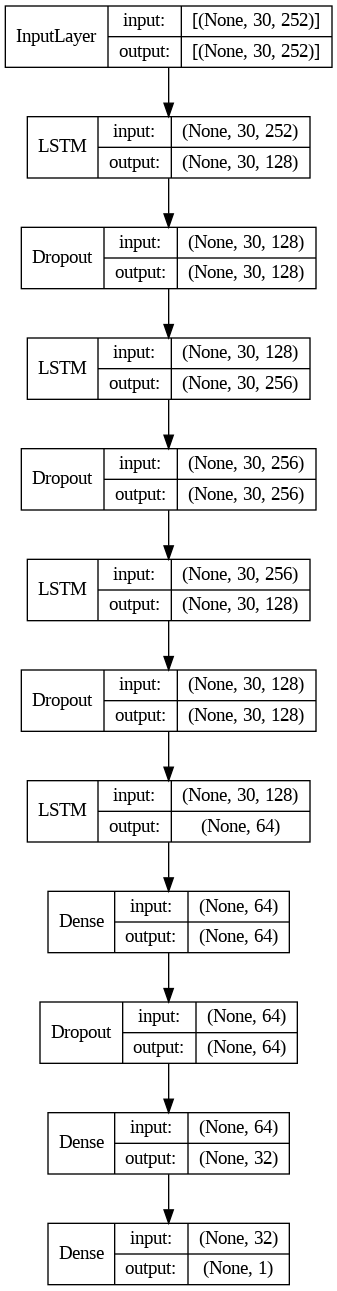

In [53]:
# Create the final model based on the hyperparameter tuning results 
  
final_model = Sequential()
final_model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(num_frame, num_people*total_num_keypoints)))
final_model.add(Dropout(best_dropout_rate))
final_model.add(LSTM(256, return_sequences=True, activation='tanh'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(LSTM(128, return_sequences=True, activation='tanh'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(LSTM(64, return_sequences=False, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
final_model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer=best_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
final_model.fit(X_reshaped,
          Y, epochs=best_epochs, batch_size= best_batch_size)

final_model.summary()

# Save the model summary in a nice table in a png

from keras.utils import plot_model
plot_model(final_model, to_file='final_model.png', show_shapes=True,show_layer_names=False)

2/2 [==============================] - 0s 130ms/step


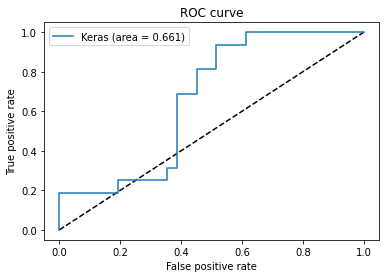

In [73]:
# Model Plots

from sklearn.metrics import roc_curve

X_test_predicted = final_model.predict(X_test_reshaped).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, X_test_predicted)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## Prediction of Test Data




In [ ]:
X_test_predicted_threshold= np.where(X_test_predicted>0.5, 1, 0)
X_test_predicted_threshold

from sklearn.metrics import accuracy_score

# Accuracy on Test Data
accuracy_score(Y_test,X_test_predicted_threshold)

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_test, X_test_predicted_threshold)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Peaceful", "Agressive"])

cm_display.plot()
plt.show()
